<a href="https://colab.research.google.com/github/glcv1group5/Capstone_CV1/blob/main/Capstone_MaskRCNN1.4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:


import seaborn as sns
#import pydicom as dcm
from glob import glob
import cv2
import os, zipfile, random, csv
import seaborn as sns
#import pydicom as dcm
from glob import glob
import cv2
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import sys
import os
ROOT_DIR = '.'


In [60]:
!pip install pydicom
import pydicom 

In [61]:
%tensorflow_version 1.x

In [62]:
#!pip install keras==2.1.6

In [63]:
#!pip install h5py==2.10.0

In [64]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [65]:
import h5py
print(h5py.__version__)

2.10.0


In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
##Mask RCNN
#!git clone https://www.github.com/matterport/Mask_RCNN.git


In [68]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [69]:
#!git clone https://github.com/leekunhee/Mask_RCNN.git

In [70]:
os.chdir('Mask_RCNN')
!python setup.py -q install

/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  % (opt, underscore_opt))
zip_safe flag not set; analyzing archive contents...


In [71]:
os.chdir('../')

In [72]:
#!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
#!ls -lh mask_rcnn_coco.h5

In [73]:
%pwd


'/content/drive/MyDrive/Kaggle'

In [74]:
# Kaggle Download

"""!pip uninstall -y kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6
!kaggle -v

!kaggle competitions list -s pneumonia
KAGGLE_DIR = '/content/sample_data/Kaggle/'
%cd {KAGGLE_DIR}
!ls
competition_name = 'rsna-pneumonia-detection-challenge'
!mkdir {competition_name}
DOWNLOAD_DIR = KAGGLE_DIR+competition_name+'/'
print(DOWNLOAD_DIR)
os.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_DIR
!kaggle competitions download -c {competition_name}
print('Download Complete')"""

"!pip uninstall -y kaggle\n!pip install --upgrade pip\n!pip install kaggle==1.5.6\n!kaggle -v\n\n!kaggle competitions list -s pneumonia\nKAGGLE_DIR = '/content/sample_data/Kaggle/'\n%cd {KAGGLE_DIR}\n!ls\ncompetition_name = 'rsna-pneumonia-detection-challenge'\n!mkdir {competition_name}\nDOWNLOAD_DIR = KAGGLE_DIR+competition_name+'/'\nprint(DOWNLOAD_DIR)\nos.environ['KAGGLE_CONFIG_DIR'] = KAGGLE_DIR\n!kaggle competitions download -c {competition_name}\nprint('Download Complete')"

In [75]:
#!chmod 600 /content/sample_data/Kaggle/kaggle.json

In [76]:
#!kaggle competitions download -c rsna-pneumonia-detection-challenge

In [77]:
"""import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)"""

'import zipfile\nfor file in os.listdir():\n    if file.endswith(".zip"):\n        with zipfile.ZipFile(file, "r") as zip_file:\n            zip_file.extractall()\n        os.remove(file)'

In [78]:
#!pip uninstall keras-nightly

In [79]:
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages/mask_rcnn-2.1-py3.7.egg
Requires: 
Required-by: 


In [80]:
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN')) 
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

In [81]:
import glob

import random
import math
import json
from imgaug import augmenters as iaa
from tqdm import tqdm

In [82]:
COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

In [83]:


class DetectorConfig(Config):
  
    
    # Give the configuration a recognizable name  
    NAME = 'pneumonia'
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
   

     # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
   

    GPU_COUNT = 1
    IMAGES_PER_GPU = 4 ##Batch size is 8 (GPUs * images/GPU)
    
    BACKBONE = 'resnet50' ## eveulate performance using pre-trained coco , can also use resnet101

    TRAIN_ROIS_PER_IMAGE = 32 ## can be reduced to 16 and checked, indicates how many (good) positive + negative ROIs from the RPN to use for training the ODN network.
    
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
    RPN_ANCHOR_SCALES = (8, 16, 32, 1, 1)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 3 ## set to 4 
    DETECTION_MAX_INSTANCES = 3 ## shd be 4
    DETECTION_MIN_CONFIDENCE = 0.5 ## reducing to identify all instances even false positive ones - >0.6
    DETECTION_NMS_THRESHOLD = 0.1 ## increae this? so to reduce the false positivies - 0.3
    #RPN_NMS_THRESHOLD  = 0.7 ## increases to 0.9

     #LOSS_WEIGHTS = {

     #   "rpn_class_loss": 1., ##improper classification of anchor boxes by RPN, higher means multiple objects will be detected

     #   "rpn_bbox_loss": 1., ## localization loss

     #   "mrcnn_class_loss": 1., ## reduce improve classification of the object

     #   "mrcnn_bbox_loss": 1., ## localization of bounding box

     #   "mrcnn_mask_loss": 1. ## indetification at pixel level needs to be increased for mask creation

    #}

    STEPS_PER_EPOCH = 500 # 500 ?




    
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  256
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  256
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

In [84]:
class DetectorDataset(utils.Dataset):
    

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('pneumonia', 1, 'Lung Opacity')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations[fp]
            self.add_image('pneumonia', image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['Target'] == 1:
                    x = int(a['x'])
                    y = int(a['y'])
                    w = int(a['width'])
                    h = int(a['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [85]:
train_labels = pd.read_csv('stage_2_train_labels.csv')

train_labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [86]:
train_labels.shape

(30227, 6)

In [87]:
train_labels.value_counts("Target")

Target
0    20672
1     9555
dtype: int64

In [88]:
train_labels_reslt = train_labels[train_labels['Target'] == 1]

In [89]:
train_labels_reslt.shape

(9555, 6)

In [90]:
def get_dicom_fps(dicom_dir):
    dicom_fps = glob.glob(dicom_dir+'/'+'*.dcm')
    return list(set(dicom_fps))

In [91]:
def parse_dataset(dicom_dir, anns): 
    image_fps = get_dicom_fps(dicom_dir)
    image_annotations = {fp: [] for fp in image_fps}
    for index, row in anns.iterrows(): 
      #  print("target",row['Target'])
        fp = os.path.join(dicom_dir, row['patientId']+'.dcm')
        image_annotations[fp].append(row)
    return image_fps, image_annotations 

In [92]:
image_fps, image_annotations = parse_dataset('stage_2_train_images', train_labels)

In [93]:
ds = pydicom.read_file(image_fps[0]) # read dicom image from filepath 
image = ds.pixel_array # get image array

In [94]:
image

array([[223, 219, 219, ..., 235, 248, 164],
       [216, 213, 213, ..., 232, 245, 161],
       [214, 211, 209, ..., 230, 243, 159],
       ...,
       [ 10,  10,  10, ..., 194, 219, 146],
       [ 11,  11,  10, ..., 194, 220, 149],
       [ 11,  11,  10, ..., 193, 219, 150]], dtype=uint8)

In [95]:
len(image_fps)

26684

In [96]:
len(image_annotations)

26684

In [97]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 202
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.10373.1517874351.219716
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.10373.1517874351.219716
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time      

In [98]:

image_fps_list = list(image_fps[:15000]) 


sorted(image_fps_list)
random.seed(42)
random.shuffle(image_fps_list)

validation_split = 0.1
split_index = int((1 - validation_split) * len(image_fps_list))

image_fps_train = image_fps_list[:split_index]
image_fps_val = image_fps_list[split_index:]

print(len(image_fps_train), len(image_fps_val))

13500 1500


In [99]:
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, 1024, 1024)
dataset_train.prepare()

In [100]:
# Show annotation(s) for a DICOM image 
test_fp = random.choice(image_fps_train)
image_annotations[test_fp]

[patientId    d7545025-6654-4cc3-83d1-99a34476c72a
 x                                           638.0
 y                                           319.0
 width                                       258.0
 height                                      458.0
 Target                                          1
 Name: 23959, dtype: object, patientId    d7545025-6654-4cc3-83d1-99a34476c72a
 x                                           177.0
 y                                           161.0
 width                                       231.0
 height                                      521.0
 Target                                          1
 Name: 23960, dtype: object]

In [101]:
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, 1024, 1024)
dataset_val.prepare()

In [102]:
"""import tensorflow as tf
tf.compat.v1.disable_eager_execution()"""

'import tensorflow as tf\ntf.compat.v1.disable_eager_execution()'

In [103]:
LEARNING_RATE = 0.006 ## reduce the learning rate as the model is complex

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")

In [104]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True,  exclude=["mrcnn_class_logits", "mrcnn_bbox_fc","mrcnn_bbox", "mrcnn_mask"]) 

In [105]:
# List of augmentations
# http://imgaug.readthedocs.io/en/latest/source/augmenters.html
augmentation = iaa.Sometimes(0.9, [
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 5.0))
])

Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO)

In [106]:
NUM_EPOCHS = 30



model.train(dataset_train, dataset_val, 
            learning_rate= LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            layers='heads',
            augmentation=None)

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: ./pneumonia20220326T0527/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeD

In [107]:
#Fine-tune all layers. 
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/10,
            epochs=,
            layers='all',
           augmentation=None)  ## no need to augment yet

history1 = model.keras_model.history.history
for k in history1: history[k] = history[k] + history1[k]

In [108]:
epochs = range(1,len(next(iter(history.values())))+1)
pd.DataFrame(history, index=epochs)

,val_loss,val_rpn_class_loss,val_rpn_bbox_loss,val_mrcnn_class_loss,val_mrcnn_bbox_loss,val_mrcnn_mask_loss,loss,rpn_class_loss,rpn_bbox_loss,mrcnn_class_loss,mrcnn_bbox_loss,mrcnn_mask_loss
1,2.804431,0.020365,1.858679,0.103179,0.426183,0.396022,3.007850,0.030388,1.946372,0.126963,0.492955,0.411169
2,2.428801,0.017859,1.493191,0.112260,0.423963,0.381521,2.570257,0.019424,1.650436,0.105099,0.410225,0.385068
3,2.508002,0.019149,1.514910,0.169681,0.417077,0.387175,2.410665,0.017850,1.514076,0.104712,0.393367,0.380652
4,2.654683,0.015754,1.858182,0.061668,0.338010,0.381048,2.407895,0.018054,1.518827,0.120790,0.380550,0.369658
5,2.487793,0.015997,1.572513,0.150155,0.382069,0.367031,2.310706,0.016803,1.444659,0.111180,0.366121,0.371919
6,2.458826,0.016056,1.593074,0.107212,0.357685,0.384759,2.268089,0.016784,1.403385,0.114942,0.364978,0.367966
7,2.373546,0.021075,1.514096,0.126320,0.359694,0.352308,2.204807,0.016205,1.345911,0.121285,0.355814,0.365546
8,2.199738,0.016212,1.336035,0.106599,0.376551,0.364276,2.119899,0.015783,1.278727,0.113248,0.348690,0.363391
9,2.443413,0.016223,1.579327,0.107566,0.372354,0.367861,2.124846,0.016356,1.292490,0.109190,0.344740,0.361998
10,2.365930,0.015274,1.503757,0.094754,0.379536,0.372514,2.017097,0.014055,1.199900,0.095962,0.347438,0.359653


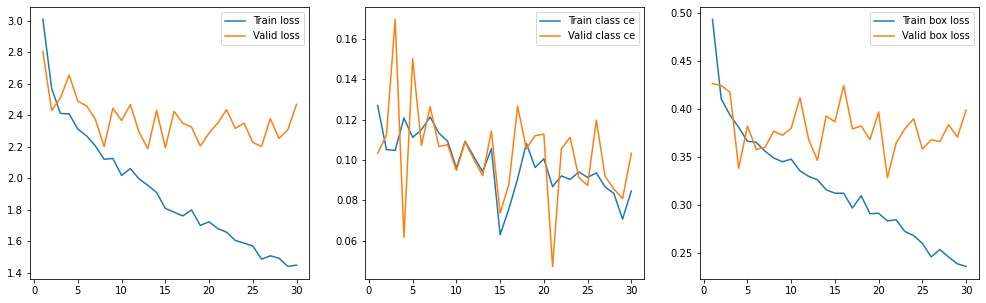

In [109]:
plt.figure(figsize=(17,5))

plt.subplot(131)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid class ce")
plt.legend()
plt.subplot(133)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid box loss")
plt.legend()

plt.show()

In [135]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

# Load trained weights (fill in path to trained weights here)
#model_path = model.find_last()
model_path = "/content/drive/MyDrive/Kaggle/pneumonia20220326T0527/mask_rcnn_pneumonia_0029.h5"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/Kaggle/pneumonia20220326T0527/mask_rcnn_pneumonia_0029.h5
Re-starting from epoch 29


In [123]:
os.chdir('/content/drive/MyDrive/Kaggle')

In [112]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)

*** No instances to display *** 

(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


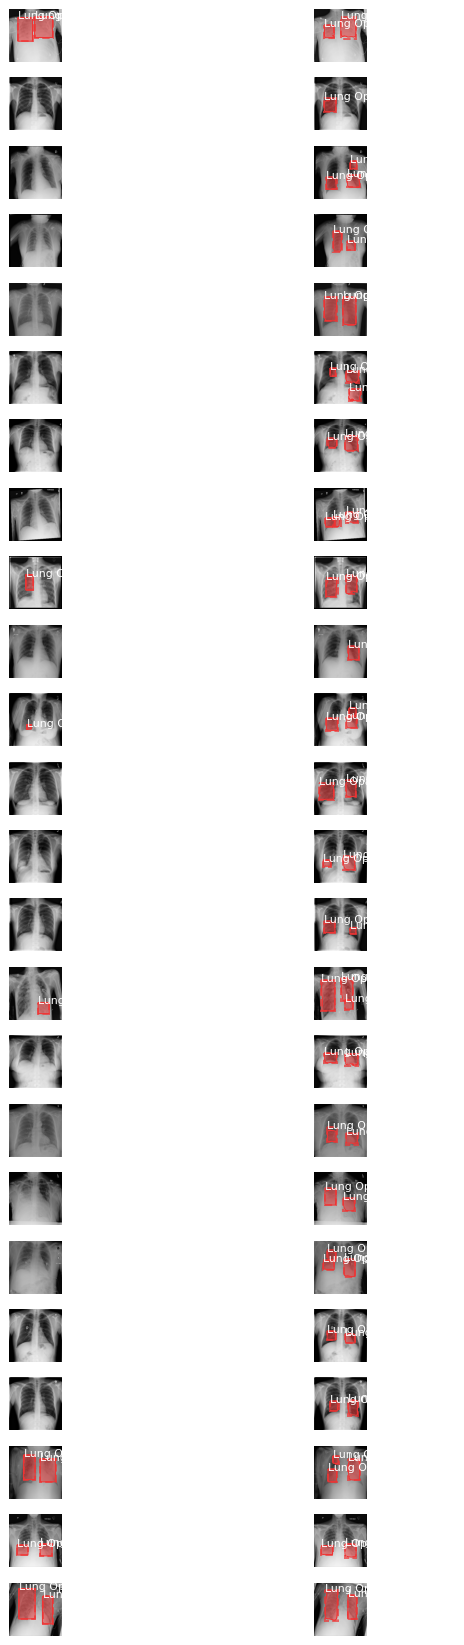

In [136]:
dataset = dataset_val
fig = plt.figure(figsize=(10, 30))

for i in range(24):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
    print(original_image.shape)
    plt.subplot(24, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(24, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

In [131]:
##Evaluation

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  nan


In [120]:
# Show stats of all trainable weights    
visualize.display_weight_stats(model)

WEIGHT NAME,SHAPE,MIN,MAX,STD
conv1_3/kernel:0,"(7, 7, 3, 64)",-0.8616,+0.8451,+0.1315
conv1_3/bias:0,"(64,)",-0.0002,+0.0004,+0.0001
bn_conv1_3/gamma:0,"(64,)",+0.0835,+2.6411,+0.5091
bn_conv1_3/beta:0,"(64,)",-2.3931,+5.3610,+1.9781
bn_conv1_3/moving_mean:0,"(64,)",-173.0470,+116.3013,+44.5654
bn_conv1_3/moving_variance:0*** Overflow?,"(64,)",+0.0000,+146335.3594,+21847.9668
res2a_branch2a_3/kernel:0,"(1, 1, 64, 64)",-0.6574,+0.3179,+0.0764
res2a_branch2a_3/bias:0,"(64,)",-0.0022,+0.0082,+0.0018
bn2a_branch2a_3/gamma:0,"(64,)",+0.2169,+1.8489,+0.4116
bn2a_branch2a_3/beta:0,"(64,)",-2.1180,+3.7332,+1.1786


In [114]:
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_4 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_4[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [115]:


os.system('jupyter nbconvert --to html Capstone_MaskRCNN.ipynb')

65280

In [116]:
%pwd

'/content/drive/MyDrive/Kaggle'

In [117]:
os.chdir('/content/drive/MyDrive/Colab Notebooks')

In [118]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

In [119]:
os.system('jupyter nbconvert --to html Capstone_MaskRCNN.ipynb')

0

In [133]:
import pickle

In [134]:
# save the model to disk
filename = 'mask_rcnn_1.3.sav'
pickle.dump(model, open(filename, 'wb'))

TypeError: ignored